<!-- Badges: -->
[![License](https://img.shields.io/github/license/QuCAI-Lab/ibm2022-quantum-spring-challenge.svg?logo=CreativeCommons&style=flat-square)](https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge/blob/dev/LICENSE.md)
[![Contributions](https://img.shields.io/badge/contributions-welcome-orange?style=flat-square)](https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge/pulls)
[![Maintenance](https://img.shields.io/badge/Maintained%3F-yes-green.svg)](https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge/graphs/commit-activity)
[![Release](https://img.shields.io/github/release/QuCAI-Lab/ibm2022-quantum-spring-challenge.svg)](https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge/releases)


<!-- Title: -->
<div align="center">
  <h1> <a href="https://challenges.quantum-computing.ibm.com/spring-2022"> IBM Quantum Spring Challenge 2022 </a> </h1>
</div>
<br>

<!-- Author: -->
<div align="center">
  <b>Developer: <a target="_blank" href="https://github.com/camponogaraviera">¹Lucas Camponogara Viera</a></b>
<br>
<b><a target="_blank" href="https://en.ntnu.edu.tw/">¹National Taiwan Normal University - NTNU, Taipei, Taiwan</a></b>.
</div>

<table class="tfo-notebook-buttons" align="head">
  <td>
    <a target="_blank" href="https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /></a>
  </td>
</table>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from tqdm.notebook import tqdm

from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import pylatexenc
import IPython

In [2]:
# If you get hit by the error "No module named watermark", run this cell twice!

#%load_ext watermark
%reload_ext watermark
%watermark -a 'LucasCamponogaraViera' -gu 'QuCAI-Lab' -ws 'https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge' -w -u -d -v -m -iv

Author: LucasCamponogaraViera

Github username: QuCAI-Lab

Website: https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge

Last updated: 2022-06-07

Python implementation: CPython
Python version       : 3.9.11
IPython version      : 8.4.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.13.0-44-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

qiskit    : 0.36.2
sys       : 3.9.11 (main, Mar 29 2022, 19:08:29) 
[GCC 7.5.0]
IPython   : 8.4.0
matplotlib: 3.5.1
numpy     : 1.22.4
pylatexenc: 2.10

Watermark: 2.3.0



In [3]:
print(IPython.sys_info())

{'commit_hash': 'bf57b0a',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/home/cesio137/anaconda3/envs/quantums/lib/python3.9/site-packages/IPython',
 'ipython_version': '8.4.0',
 'os_name': 'posix',
 'platform': 'Linux-5.13.0-44-generic-x86_64-with-glibc2.31',
 'sys_executable': '/home/cesio137/anaconda3/envs/quantums/bin/python3.9',
 'sys_platform': 'linux',
 'sys_version': '3.9.11 (main, Mar 29 2022, 19:08:29) \n[GCC 7.5.0]'}


# Tight-binding Model

<div>
<img src="attachment:tight-binding.png" width="400"/>
</div>

The tight-binding model is a quantum mechanical picture used to describe the conductance of electrons in solid-state materials. In this model, each atom is treated as a lattice site and the particle needs energy $\epsilon_i$ to occupy that site. The electron can tunnel from a site to its neighbors with an energy cost of $J$. The following Hamiltonian describes this model:

$$H_{\rm tb}/\hbar = \sum_i \epsilon_i Z_i + J \sum_{\langle i,j \rangle} (X_i X_j + Y_i Y_j)$$

The first term in the Hamiltonian describes the on-site energy of each site, and the second term describes the interaction energy between neighboring lattice sites. In the presence of a periodic lattice potential, the wavefunction of a given quantum particle overlaps neighboring lattice sites, leading to extended Bloch wavefunctions. In a uniform lattice, where all the site energies are equal ($\epsilon_i=0$), the electron propagation is linear in time and is described by a continuous-time quantum random walk. This is in contrast to classical diffusive transport, where the propagation is quadratically slower in time.

The system Hamiltonian allows us to determine how the quantum state evolves with time. This time evolution is governed by the Schrodinger equation:

$$ i \hbar \frac{\partial}{\partial t}|\psi(t)\rangle = H |\psi(t)\rangle $$

In case of a time-independent Hamiltonian (a Hamiltonian that doesn't change with time), the solution to the Schrodinger equation will take the form below:

$$ |\psi(t)\rangle = e^{-i H t / \hbar} |\psi(0)\rangle $$

In this exercise we study the time dynamics under the tight-binding Hamiltonian, and construct a Trotterized circuit for its time evolution.

## 1. Time evolution under the tight-binding Hamiltonian

First, let's consider time evolution under the tight-binding Hamiltonian with 3 sites. Here we'll set $J=1$, and $\epsilon_i=0$ for a uniform lattice.

In [4]:
# Import Pauli operators (I, X, Y, Z)
from qiskit.opflow import I, X, Y, Z

J = 1

# tight-binding Hamiltonian
def H_tb():
    # Interactions (I is the identity matrix; X and Y are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    
    # Sum interactions
    H = J*(XXs + YYs)
    
    # Return Hamiltonian
    return H

In [5]:
# Unitary evolution under the tight-binding Hamiltonian
def U_tb(t):
    H = H_tb()
    return (t * H).exp_i()

We initialize the state of our system to $|100\rangle$, and track the probabilities of the states $|100\rangle, |010\rangle, |001\rangle$. These values correspond to the probability of finding the particle on each different site of our lattice.

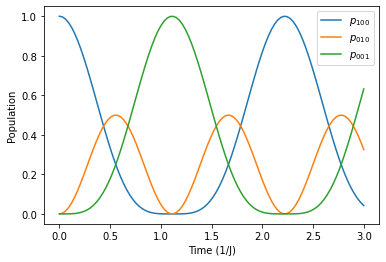

In [6]:
# Import qubit states Zero (|0>) and One (|1>)
from qiskit.opflow import Zero, One

# Define array of time points
ts = np.linspace(0, 3, 100) # DO NOT CHANGE THIS

initial_state=One^Zero^Zero

state_t=[U_tb(float(t)) @ initial_state for t in ts]

p_100= [np.abs( (~(One^Zero^Zero) @ state).eval() )**2 for state in state_t]
p_010= [np.abs( (~(Zero^One^Zero) @ state).eval() )**2 for state in state_t]
p_001= [np.abs( (~(Zero^Zero^One) @ state).eval() )**2 for state in state_t]

plt.figure(facecolor='white')
plt.plot(ts, p_100, label=r'$p_{100}$')
plt.plot(ts, p_010, label=r'$p_{010}$')
plt.plot(ts, p_001, label=r'$p_{001}$')
plt.xlabel(r'Time (1/J)')
plt.ylabel(r'Population')
plt.legend()
plt.show()

## 2. Trotterization

To execute the unitary time evolution on a [circuit model](https://qiskit.org/documentation/apidoc/circuit.html) quantum computer, we must decompose $U_{\text{tb}}(t)$ into a product of single and two-qubit gates that are native to the quantum computer. One method to accomplish this is [Trotterization](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_Formulas), also refered to as Trotter-Suzuki decomposition. 

Below, we show an example Trotterization as outlined in \[1-2\].

Since the [Pauli operators do not commute](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) with each other, the exponential $U_{\text{tb}}(t)$ cannot be split into a product of simpler exponentials. However, we can approximate $U_{\text{tb}}(t)$ as a product of simpler exponentials through Trotterization. Consider a subsystem of 2 spin-1/2 particles within the larger 3 spin system. The Hamiltonian on spins $i$ and $j$ ($i,j \in \{0,1,2\}$) would be $H^{(i,j)}_{\text{tb}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$. Rewritting $U_{\text{tb}}(t)$ in terms of the two possible subsystems within the total $N=3$ system you will simulate,

$$
U_{\text{tb}}(t) = \exp\left[-i t \left(H^{(0,1)}_{\text{tb}} + H^{(1,2)}_{\text{tb}} \right)\right].
$$

$H^{(0,1)}_{\text{tb}}$ and $H^{(1,2)}_{\text{tb}}$ do not commute, so $U_{\text{tb}}(t) \neq \exp\left(-i t H^{(0,1)}_{\text{tb}}\right) \exp\left(-i t H^{(1,2)}_{\text{tb}} \right)$. But, this product decomposition can be approximated with Trotterization which says $U_{\text{tb}}(t)$ is approximately a short evolution of $H^{(0,1)}_{\text{tb}}$ (time = $t/n$) and followed by a short evolution of $H^{(1,2)}_{\text{tb}}$ (time = $t/n$) repeated $n$ times

$$
\begin{align}
U_{\text{tb}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{tb}} + H^{(1,2)}_{\text{tb}} \right)\right] \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{tb}} \right)\right]^n.
\end{align}
$$

$n$ is the number of Trotter steps, and as $n$ increases, the approximation becomes more accurate. (Note that how the unitary operator is split up into subsystems for Trotterization is not necessarily unique.) The decomposition goes further. Within each 2 spin subsystems, the Pauli operator pairs ($\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$) commute. This means we can decompose the exponential of a subsystem Hamiltonian ($H^{(i,j)}_{\text{tb}}$) into a product of even simpler exponentials getting us closer to a gate implementation of $U_{\text{tb}}(t)$

$$
\begin{align}
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{tb}} \right)\right]^n \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} \right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} \right)\right)\right]^{n} \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \right]^{n}
\end{align}
$$

For simplicity, and to use more common notation, let's rename the products with $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, and $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and rewrite the Trotterized $U_{\text{tb}}(t)$
$$
U_{\text{tb}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)}  XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)}\right]^{n}
$$
And that's it! We have now approximately decomposed $U_{\text{tb}}(t)$ into two-qubit gates $XX(t)$ and $YY(t)$. These gates are not native to superconducting qubits, but in Section 2, they will be further decomposed into native single and two-qubit gates with *further details found in the supplementary material.*


\[1\] Y. Salathe, et al., *Digital Quantum Simulation of Spin Models with Circuit Quantum Electrodynamics*, [Phys. Rev. X **5**, 021027 (2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021027)

\[2\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]


### 2.1 Building the individual Pauli unitaries

In this section we build ZZ(t), XX(t), and YY(t) operations using single- and two-qubit gates.

In [7]:
t = Parameter('t')

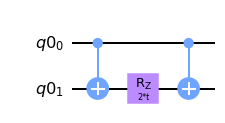

In [8]:
# Build a subcircuit for ZZ(t) from single- and two-qubit gates

ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

ZZ_qc.draw(output='mpl')

### 2.2 Clifford gates

Clifford gates are quantum operators that map Pauli operators to other Pauli operators. The Hadamard gate ($H$) and the phase gate ($S$) are examples of single-qubit Clifford gates.

$$H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\1 & -1\\ \end{pmatrix}$$

$HZH^\dagger=X$, and $HXH^\dagger=Z$. Since the Hadamard gate is a Hermitian operator, $H=H^\dagger$.

$$S=\begin{pmatrix} 1 & 0 \\0 & i\\ \end{pmatrix}$$

$SXS^\dagger=Y$, and $SYS^\dagger=-X$.

Using the Clifford gates, we can transform the $e^{i ZZ t}$ to $e^{i XX t}$ and $e^{i YY t}$

#### .
<div class="alert alert-block alert-danger">
    
<b>Challenge question 1a</b> 

Build a subcircuit for XX(t) from single- and two-qubit gates
    
</div>

##### .
<div class="alert alert-block alert-warning">
<b>Equations:</b> deriving the circuit for the XX(t) gate.
</div>

One should note that $e^{-itXX}$ is shorthand for $e^{-itX \otimes X}.$ Also, recall from the spectral decomposition theorem for Normal matrices that any Normal operator $\hat{O}$ in a Hilbert space $\mathcal{H}$ of dimension $\dim \mathcal{H} =d$ is unitarily diagonalizable and has a spectral (eigenvalue) decomposition in terms of the outer product representation, and in the basis of its eigenvectors, of the form:

$$ \hat{O} = \sum_{j=1}^{d}= o_j P_{o_j} = \sum_{j=1}^{d} o_j |o_j \rangle \langle o_j|. \tag{1} $$

Where:

- $o_j$ and $P_{o_j}$ are the corresponding eigenvalue and projector operator of the observable $\hat{O}$, respectively. 

- $\{o_j\}|_{j=1}^d$ is a basis set of $d$ linearly independent orthonormal eigenvectors $|o_j\rangle$ of $\hat{O}$ with eigenvalue $o_j$.

To see this is true, note that:

$$ \Bigg( \sum_{j=1}^{d} o_j |o_j \rangle \langle o_j| \Bigg) |o_k \rangle =  \sum_{j=1}^{d} o_j |o_j \rangle \delta_{jk}= o_k |o_k \rangle = \hat{O} |o_k \rangle.$$

Moving on... Since Pauli operators are all involutory operators, i.e, their eigenvalues are $o_j = \pm 1$, one then has 

$$X = \sum_{j=1}^{d} x_j |x_j \rangle \langle x_j| = |+\rangle\langle +|-|-\rangle\langle -|. \tag{2}$$

Where $$ |\pm\rangle \equiv \frac{1}{\sqrt{2}}(|0\rangle\pm|1\rangle) \tag{3} $$ 

denotes the two orthonormal eigenstates (eigenvectors) of the Pauli $X$-gate according to:

$$X |+\rangle = \frac{1}{\sqrt{2}}(X|0\rangle+X|1\rangle)=\frac{1}{\sqrt{2}}(|1\rangle+|0\rangle)=|+\rangle, \tag{4}$$
$$X |-\rangle = \frac{1}{\sqrt{2}}(X|0\rangle-X|1\rangle) =\frac{1}{\sqrt{2}}(|1\rangle-|0\rangle)=-|-\rangle. \tag{5}$$

With that, one has:

\begin{eqnarray}
XX &\equiv& X\otimes X = (|+\rangle\langle +|-|-\rangle\langle -|)\otimes(|+\rangle\langle +|-|-\rangle\langle -|) \tag{6}\\
&=& (|+\rangle\langle +|) \otimes (|+\rangle\langle +|) - (|+\rangle\langle +|) \otimes (|-\rangle\langle -|) - (|-\rangle\langle -|)\otimes (|+\rangle\langle +|) + (|-\rangle\langle -|) \otimes (|-\rangle\langle -|) \tag{7} \\
&=& (|++\rangle\langle ++|)+(|--\rangle\langle --|)-(|+-\rangle\langle +-|)+(|-+\rangle\langle -+|) \tag{8} \\
&\implies & e^{-itX \otimes X} = e^{-it}\bigg(|++\rangle\langle ++|+|--\rangle\langle --|\bigg)+e^{it}\bigg(|+-\rangle\langle +-|+|-+\rangle\langle -+|\bigg) \tag{9}.
\end{eqnarray}

- Eq. (7) was obtained from Eq. (6) using the distributive property:

$$(|a\rangle + |b\rangle)\otimes(|c\rangle + |d\rangle)=|a\rangle \otimes |c\rangle + |a\rangle \otimes |d\rangle + |b\rangle \otimes |c\rangle + |b\rangle \otimes |d\rangle. \tag{10}$$

- Eq. (8) was obtained from Eq. (7) using $(A\otimes B)(C\otimes D)=AC\otimes BD$, or equivalently:

$$|a\rangle \langle c| \otimes |b\rangle \langle d|  = (|a\rangle \otimes |b\rangle)(\langle c| \otimes \langle d|) \doteq |ab\rangle\langle cd|. \tag{11}$$

- Eq. (9) is left as an exercise (see the next cell for a motivation).

Applying a Hadamard gate to change between the $X$ and $Z$ bases ($H|0\rangle = R_y(\pi/2)|0\rangle = |+\rangle$ and $H|1\rangle = R_y(-\pi/2)|0\rangle = |-\rangle$), yields

\begin{eqnarray}
e^{-itX \otimes X} &=& e^{-it}\left[(H\otimes H)|00\rangle\langle 00|(H\otimes H)+(H\otimes H)|11\rangle\langle 11|(H\otimes H)\right]+e^{it}\left[(H\otimes H)|01\rangle\langle 01|(H\otimes H)+(H\otimes H)|10\rangle\langle 10|(H\otimes H)\right] \tag{12}\\
& =& (H\otimes H)\left[e^{-it}(|00\rangle\langle 00|+|11\rangle\langle 11|)+e^{it}(|01\rangle\langle 01|+|10\rangle\langle 10|)\right](H\otimes H) \tag{13}\\
& =& (H\otimes H)e^{-itZ\otimes Z}(H\otimes H) \tag{14}\\
& =& (H\otimes H)C_{x}^{01}\big(I\otimes e^{-itZ}\big)C_{x}^{01}(H\otimes H) \tag{15}\\
&  =& (H\otimes H)C_{x}^{01}\big(I\otimes RZ(2t)\big)C_{x}^{01}(H\otimes H). \tag{16}
\end{eqnarray}

**Note**: *some steps have been omitted. I encourage the reader to verify them.*

**Hint:** you can find some of the solutions in [this jupyter notebook](https://github.com/QuCAI-Lab/ibm2021-open-science-prize/blob/dev/supplementary.ipynb).


Specifically, show that:

\begin{eqnarray}
(|a\rangle + |b\rangle)\otimes(|c\rangle + |d\rangle)&=&|a\rangle \otimes |c\rangle + |a\rangle \otimes |d\rangle + |b\rangle \otimes |c\rangle + |b\rangle \otimes |d\rangle, \tag{17} \\
(|a\rangle \langle c|) \otimes (|b\rangle \langle d|)  &=& \big(|a\rangle \otimes |b\rangle\big)\big(\langle c| \otimes \langle d|\big), \tag{18}\\
|++\rangle\langle ++|&=&(H\otimes H)|00\rangle\langle 00|(H\otimes H), \tag{19}\\
|--\rangle\langle --|&=&(H\otimes H)|11\rangle\langle 11|(H\otimes H), \tag{20}\\
|+-\rangle\langle +-|&=&(H\otimes H)|01\rangle\langle 01|(H\otimes H), \tag{21}\\
|-+\rangle\langle -+|&=&(H\otimes H)|10\rangle\langle 10|(H\otimes H), \tag{22}\\
e^{-itZ\otimes Z} &=& C_{x}^{01}\big(I\otimes e^{-itZ}\big)C_{x}^{01}, \tag{23}\\
e^{-itZ} &=& RZ(2t) \tag{24}.
\end{eqnarray}

You can open a pool request to share your contribution. 


**Motivation:** To demonstrate Eq. (9), one should recall that if $\hat{O}$ is a Hermitian or Unitary operator then it is also a Normal operator and, therefore, has a spectral decomposition in terms of the outer product representation in the form $\hat{O} = \sum_j o_j|o_j\rangle \langle o_j|$ according to the spectral decomposition theorem for Normal matrices. In this case, it is possible to write the operator function (matrix function) on a normal matrix as:

$$f(\hat{O})= \sum_j f(o_j) |o_j\rangle \langle o_j|,$$

which is equivalent to (writing $\hat{O} = UDU^{\dagger}$)

\begin{eqnarray}
f(\hat{O}) = Uf(D)U^{\dagger}.
\end{eqnarray}


For the exponential function over the field of the complex numbers, it becomes:

$$ e^{i\theta\hat{O}} = \sum_{j=1}^n e^{i\theta o_j} |o_j\rangle \langle o_j| = e^{i\theta o_1} |o_{1}\rangle \langle o_{1}| + \cdots + e^{i\theta o_n} |o_{n}\rangle \langle o_{n}|. \tag{25}$$

To see this is true, recall that the eigenvalues of a matrix are multiplied by a scalar when the matrix is multiplied by the same scalar, while the eigenvectors are left unchanged. One can extend this identity to a tensor product of Normal operators noting that `the tensor product of two Hermitian operators is another Hermitian operator`. With that, one should be able to obtain Eq. (9).

##### .
<div class="alert alert-block alert-info">
<b>Identities:</b> verifying some of the above identities using <b>NumPy</b>, <b>SymPy</b> and <b>Qiskit statevector</b>. 
</div>

In [8]:
# Defining states and gates with NumPy:

zero=np.array([[1,0]]) # row-like numpy array representing the state |0>.
one=np.array([[0,1]])  # row-like numpy array representing the state |1>.

zeros=np.kron(zero.T,zero.T)@np.kron(zero,zero) # Outer product |00><00|.
ones=np.kron(one.T,one.T)@np.kron(one,one)      # Outer product |11><11|.
zerone=np.kron(zero.T,one.T)@np.kron(zero,one)  # Outer product |01><01|.
onezero=np.kron(one.T,zero.T)@np.kron(one,zero) # Outer product |10><10|.

plus=1/(np.sqrt(2))*(zero+one)   # 1/[sqrt(2)](|0> + |1>).
minus=1/(np.sqrt(2))*(zero-one)  # 1/[sqrt(2)](|0> - |1>).
sigma1 = np.array([[0,1],[1,0]]) # Pauli-X gate.
had = (1/np.sqrt(2))*np.array([[1,1],[1,-1]]) # Hadamard gate.

*Verifying Hermiticity* 

$X \otimes X = (X \otimes X)^{\dagger}:$

In [9]:
(np.kron(sigma1, sigma1) == np.kron(sigma1, sigma1).conj().T).all() 

True

*Verifying Identity* 

$|++\rangle\langle ++|=(H\otimes H)|00\rangle\langle 00|(H\otimes H):$

In [10]:
(np.kron(plus.T,plus.T)@np.kron(plus,plus) == (np.kron(had,had))@zeros@(np.kron(had,had))).all()

True

*Verifying Identity* 

$|--\rangle\langle --|=(H\otimes H)|11\rangle\langle 11|(H\otimes H):$

In [11]:
(np.kron(minus.T,minus.T)@np.kron(minus,minus) == (np.kron(had,had))@ones@(np.kron(had,had))).all()

True

*Verifying Identity* 

$|+-\rangle\langle +-|=(H\otimes H)|01\rangle\langle 01|(H\otimes H):$

In [12]:
(np.kron(plus.T,minus.T)@np.kron(plus,minus) == (np.kron(had,had))@(zerone)@(np.kron(had,had))).all()

True

*Verifying Identity* 

$|-+\rangle\langle -+|=(H\otimes H)|10\rangle\langle 10|(H\otimes H):$

In [13]:
(np.kron(minus.T,plus.T)@np.kron(minus,plus) == (np.kron(had,had))@(onezero)@(np.kron(had,had))).all()

True

*Verifying Identity* 

$(|a\rangle \langle c|) \otimes (|b\rangle \langle d|)  = \big(|a\rangle \otimes |b\rangle\big)\big(\langle c| \otimes \langle d|\big):$

In [14]:
# Using SymPy

import sympy as sym
a1,a2,b1,b2,c1,c2,d1,d2=sym.symbols('a1,a2,b1,b2,c1,c2,d1,d2')

a=sym.Matrix([[a1,a2]]).T # This is a column vector.
b=sym.Matrix([[b1,b2]]).T # This is a column vector.
c=sym.Matrix([[c1,c2]]) # This is a row vector.
d=sym.Matrix([[d1,d2]]) # This is a row vector.

# Reading dimensions.
a.shape, b.shape, c.shape, d.shape

((2, 1), (2, 1), (1, 2), (1, 2))

In [15]:
# Using outer product:

(np.kron(np.outer(a,c),np.outer(b,d)) == (np.kron(a,b))@(np.kron(c,d))).all() 

True

In [16]:
# Using @:

(np.kron(a@c, b@d) == (np.kron(a,b))@(np.kron(c,d))).all() 

True

In [17]:
# Visualizing the left side (using outer product).

np.kron(np.outer(a,c),np.outer(b,d))

array([[a1*b1*c1*d1, a1*b1*c1*d2, a1*b1*c2*d1, a1*b1*c2*d2],
       [a1*b2*c1*d1, a1*b2*c1*d2, a1*b2*c2*d1, a1*b2*c2*d2],
       [a2*b1*c1*d1, a2*b1*c1*d2, a2*b1*c2*d1, a2*b1*c2*d2],
       [a2*b2*c1*d1, a2*b2*c1*d2, a2*b2*c2*d1, a2*b2*c2*d2]], dtype=object)

In [18]:
# Visualizing the left side (using @).

np.kron(a@c, b@d)

array([[a1*b1*c1*d1, a1*b1*c1*d2, a1*b1*c2*d1, a1*b1*c2*d2],
       [a1*b2*c1*d1, a1*b2*c1*d2, a1*b2*c2*d1, a1*b2*c2*d2],
       [a2*b1*c1*d1, a2*b1*c1*d2, a2*b1*c2*d1, a2*b1*c2*d2],
       [a2*b2*c1*d1, a2*b2*c1*d2, a2*b2*c2*d1, a2*b2*c2*d2]], dtype=object)

In [19]:
# Visualizing the right side.

(np.kron(a,b))@(np.kron(c,d))

array([[a1*b1*c1*d1, a1*b1*c1*d2, a1*b1*c2*d1, a1*b1*c2*d2],
       [a1*b2*c1*d1, a1*b2*c1*d2, a1*b2*c2*d1, a1*b2*c2*d2],
       [a2*b1*c1*d1, a2*b1*c1*d2, a2*b1*c2*d1, a2*b1*c2*d2],
       [a2*b2*c1*d1, a2*b2*c1*d2, a2*b2*c2*d1, a2*b2*c2*d2]], dtype=object)

*Verifying Identity* 

$H|0\rangle = R_y(\pi/2)|0\rangle = |+\rangle:$

Note that, in this case, there is no need to code numpy arrays as column vectors, but I will do it just for fun.

In [20]:
zero = np.array([[1,0]]).T # |0>.
one = np.array([[0,1]]).T # |1>.

def RY(theta):
    '''
    Function that defines the RX(theta) gate.
    '''
    RY = np.array([
        [np.cos(theta/2),-np.sin(theta/2)],
        [np.sin(theta/2), np.cos(theta/2)]
                 ])
    return RY

ry_pi2 = RY(np.pi/2)
ry_mpi2 = RY(-np.pi/2)

In [21]:
had@zero # H|0>.

array([[0.70710678],
       [0.70710678]])

In [22]:
ry_pi2@zero # RY(pi/2)|0>.

array([[0.70710678],
       [0.70710678]])

    ┌───┐
q1: ┤ H ├
    └───┘
Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


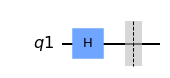

In [23]:
from qiskit import assemble
sim = Aer.get_backend('aer_simulator')  # Define the simulator.

qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.h(0)  # Apply the Hadamard gate on qubit 0.
print(qc)  # Print the circuit.
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.

qc.draw(output='mpl')  

    ┌─────────┐
q2: ┤ Ry(π/2) ├
    └─────────┘
Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


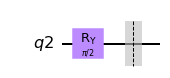

In [24]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.ry(np.pi/2,0)  # Apply the RY(pi/2) gate on qubit 0.
print(qc)  # Print the circuit.
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.

qc.draw(output='mpl')  

*Verifying Identity* 

$H|1\rangle = R_y(-\pi/2)|0\rangle = |-\rangle:$

In [25]:
had@one # H|1>.

array([[ 0.70710678],
       [-0.70710678]])

In [26]:
ry_mpi2@zero # RY(-pi/2)|0>.

array([[ 0.70710678],
       [-0.70710678]])

    ┌───┐┌───┐
q3: ┤ X ├┤ H ├
    └───┘└───┘
Statevector([ 0.70710678-8.65956056e-17j, -0.70710678+8.65956056e-17j],
            dims=(2,))


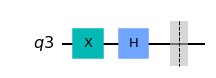

In [27]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.x(0)  # Apply the Pauli-X gate on qubit 0.
qc.h(0)  # Apply the Hadamard gate on qubit 0.
print(qc)  # Print the circuit.
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.

qc.draw(output='mpl')  

    ┌──────────┐
q4: ┤ Ry(-π/2) ├
    └──────────┘
Statevector([ 0.70710678+0.j, -0.70710678+0.j],
            dims=(2,))


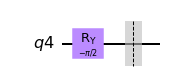

In [28]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.ry(-np.pi/2,0)  # Apply the RY(-pi/2) gate on qubit 0.
print(qc)  # Print the circuit.
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.

qc.draw(output='mpl')  

##### .

<div class="alert alert-block alert-success">
<b>Solution:</b> let's implement the obtained $XX(t)$ gate in qiskit.
</div>

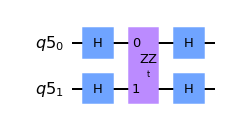

In [29]:
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

###EDIT CODE BELOW (add Clifford operator)
XX_qc.h([0,1])
###DO NOT EDIT BELOW

XX_qc.append(ZZ, [0,1])

###EDIT CODE BELOW (add Clifford operator)
XX_qc.h([0,1])
###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

XX_qc.draw(output='mpl')

In [ ]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex1a

grade_ex1a(XX_qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


#### .
<div class="alert alert-block alert-danger">
    
<b>Challenge question 1b</b> 

Build a subcircuit for YY(t) from single- and two-qubit gates
    
</div>

##### .
<div class="alert alert-block alert-warning">
<b>Equations:</b> deriving the circuit for the YY(t) gate.
</div>

One should note that $e^{-itYY}$ is shorthand for $e^{-itY \otimes Y}$. Following the same thought process as before, one writes the Pauli operator $Y$ in the basis of its eigenvectors:

$$Y=|\oplus\rangle\langle \oplus|-|\ominus\rangle\langle \ominus|,$$

where

$$|+y\rangle \equiv |\oplus\rangle = \frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle) \text{ and } |-y\rangle \equiv |\ominus\rangle = \frac{1}{\sqrt{2}}(|0\rangle-i|1\rangle).$$

Therefore,

\begin{eqnarray}
YY &\equiv& Y \otimes Y = (|\oplus\oplus\rangle\langle \oplus\oplus|+|\ominus\ominus\rangle\langle \ominus\ominus|)-(|\oplus\ominus\rangle\langle \oplus\ominus|+|\ominus\oplus\rangle\langle \ominus\oplus|) \\
&\implies& e^{-itY\otimes Y} = e^{-it}(|\oplus\oplus\rangle\langle \oplus\oplus|+|\ominus\ominus\rangle\langle \ominus\ominus|) + e^{it}(|\oplus\ominus\rangle\langle \oplus\ominus|+|\ominus\oplus\rangle\langle \ominus\oplus|).
\end{eqnarray}

The next step is to apply a basis change, as follows:

$$|\oplus\rangle = SH|0\rangle = R_x(-\pi/2)|0\rangle  \text{ and }  |\ominus\rangle = SH|1\rangle = R_x(\pi/2)|0\rangle,$$

such that

\begin{align}
e^{-itY\otimes Y} & = (S\otimes S)(H\otimes H)\Big(e^{-it}(|00\rangle\langle 00|+|11\rangle\langle 11|)+e^{it}(|01\rangle\langle 01|+|10\rangle\langle 10|)\Big)(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \\
& = (S\otimes S)(H\otimes H)e^{-itZ \otimes Z}(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \\
& = (S\otimes S)e^{-itX\otimes X}(S^{\dagger}\otimes S^{\dagger}) \\
& = (S\otimes S)(H\otimes H)C_{x}^{01}\big(I\otimes e^{-itZ}\big)C_{x}^{01}(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \\
& = (S\otimes S)(H\otimes H)C_{x}^{01}\big(I\otimes RZ(2t)\big)C_{x}^{01}(H\otimes H)(S^{\dagger}\otimes S^{\dagger}).
\end{align}

##### .
<div class="alert alert-block alert-info">
<b>Identities:</b> verifying some of the above gate identities with <b>NumPy</b> and <b>Qiskit statevector</b>. 
</div>

*Verifying Identity* 

$SH|0\rangle = R_x(-\pi/2)|0\rangle = |\oplus\rangle:$

Note: this time I will represent ket vectors |0> and |1> using ordinary numpy arrays.

In [30]:
zero = np.array([1,0]) # NumPy array representing the state |0>.
one = np.array([0,1]) # NumPy array representing the state |1>.
s =  np.array([[1,0],[0,1j]]) #  Phase gate S a.k.a P gate (square-root of Pauli-Z).

def RX(theta):
    '''
    Function that defines the RX(theta) gate.
    '''
    RX = np.array([
        [np.cos(theta/2),-1j*np.sin(theta/2)],
        [-1j*np.sin(theta/2), np.cos(theta/2)]
                 ])
    return RX

rx_pi2 = RX(np.pi/2)
rx_mpi2 = RX(-np.pi/2)

In [31]:
(s@had)@zero # SH|0>.

array([0.70710678+0.j        , 0.        +0.70710678j])

In [32]:
rx_mpi2@zero # RX(-pi/2)|0>.

array([0.70710678+0.j        , 0.        +0.70710678j])

    ┌───┐┌───┐
q6: ┤ H ├┤ S ├
    └───┘└───┘
Statevector([0.70710678+0.j        , 0.        +0.70710678j],
            dims=(2,))


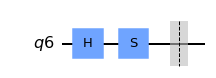

In [33]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.h(0)  # Apply the Hadamard gate on qubit 0.
qc.s(0)  # Apply the S gate on qubit 0.
print(qc)  # Print the circuit.
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.

qc.draw(output='mpl')  

    ┌──────────┐
q7: ┤ Rx(-π/2) ├
    └──────────┘
Statevector([0.70710678+0.j        , 0.        +0.70710678j],
            dims=(2,))


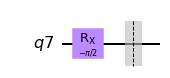

In [34]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.rx(-np.pi/2,0)  # Apply the RX(-pi/2) gate on qubit 0.
print(qc)  # Print the circuit.
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.

qc.draw(output='mpl')  

*Verifying Identity* 

$SH|1\rangle = R_x(\pi/2)|0\rangle = |\ominus\rangle:$

In [35]:
(s@had)@one # SH|1>.

array([0.70710678+0.j        , 0.        -0.70710678j])

In [36]:
rx_pi2@zero # RX(pi/2)|0>.

array([0.70710678+0.j        , 0.        -0.70710678j])

    ┌───┐┌───┐┌───┐
q8: ┤ X ├┤ H ├┤ S ├
    └───┘└───┘└───┘
Statevector([ 7.07106781e-01-8.65956056e-17j,
             -8.65956056e-17-7.07106781e-01j],
            dims=(2,))


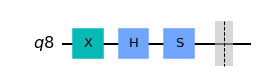

In [37]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.x(0)  # Apply the Pauli-X gate on qubit 0.
qc.h(0)  # Apply the Hadamard gate on qubit 0.
qc.s(0)  # Apply the S gate on qubit 0.
print(qc)  # Print the circuit.
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.

qc.draw(output='mpl') 

    ┌─────────┐
q9: ┤ Rx(π/2) ├
    └─────────┘
Statevector([0.70710678+0.j        , 0.        -0.70710678j],
            dims=(2,))


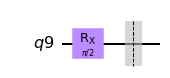

In [38]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.rx(np.pi/2,0)  # Apply the RX(-pi/2) gate on qubit 0.
print(qc)  # Print the circuit.
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.

qc.draw(output='mpl')  

##### .
<div class="alert alert-block alert-success">
<b>Solution:</b> let's implement the obtained $YY(t)$ gate in qiskit.
</div>

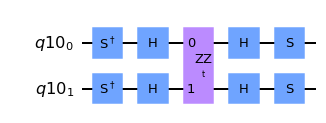

In [39]:

YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

###EDIT CODE BELOW (add Clifford operator)
YY_qc.sdg([0,1])
YY_qc.h([0,1])

###DO NOT EDIT BELOW

YY_qc.append(ZZ, [0,1])

###EDIT CODE BELOW (add Clifford operator)
YY_qc.h([0,1])
YY_qc.s([0,1])

###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

YY_qc.draw(output='mpl')

In [ ]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex1b

grade_ex1b(YY_qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### 2.3 Building the trotterizated circuit

$X_iX_j$ and $Y_iY_j$ operators commute:

$$[X_iX_j, Y_iY_j]= X_iX_j.Y_iY_j - Y_iY_j.X_iX_j = Z_iZ_j-(-Z_i)(-Z_j)=0.$$

Therefore, we can decompose $e^{i t (X_iX_j + Y_iY_j)}$ as $e^{i t X_iX_j} e^{i t Y_iY_j}$. Furthermore, if $i\neq j \neq k \neq l$ then $[X_iX_j,X_kX_l]=0$. Based on this, we can decompose each trotterized evolution time step to two blocks:

$$U(\Delta t) \approx \Big(\prod_{i \in \rm{odd}} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} \Big)  \Big(\prod_{i \in \rm{even}} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} \Big)$$

<div class="alert alert-block alert-info">
<b>Note:</b> it is important to note that
$$e^{itX\otimes X\otimes I}e^{itI\otimes Y\otimes Y} \ne e^{itI\otimes Y\otimes Y}e^{itX\otimes X\otimes I}.$$
</div>

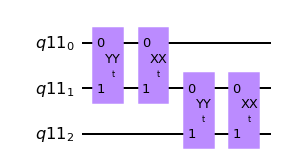

In [40]:
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

Trot_qc.draw(output='mpl')

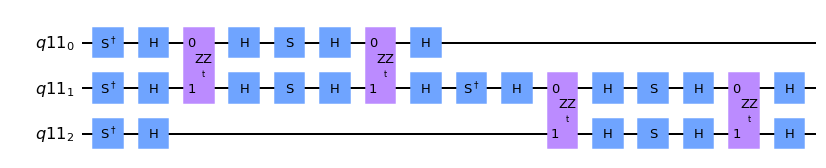

In [41]:
Trot_qc.decompose().draw(output='mpl')

#### .
<div class="alert alert-block alert-danger">
    
<b>Challenge question 1c</b> 

Create the trotterized circuit and output the unitary associated with the circuit
    
</div>

##### .
<div class="alert alert-block alert-info">
<b>Tip:</b> for this solution, there is no need to prepare the circuit in the initial state $|100\rangle$. 
    
<b>Digression:</b> just for curiosity, let's see how to create and verify a circuit that prepares the initial state $|100\rangle$ using qiskit.
</div>

            
q65_0: ─────
            
q65_1: ─────
       ┌───┐
q65_2: ┤ X ├
       └───┘
Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


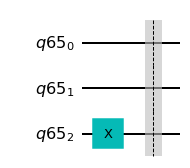

In [60]:
# Circuit that prepares the initial state |100>.

from qiskit import assemble

sim = Aer.get_backend('aer_simulator')  # Tell Qiskit how to simulate the circuit.

qr = QuantumRegister(3)  # Define the number of qubits in the quantum circuit (0,1,2).
qc = QuantumCircuit(qr)
qc.x(2)  # Apply the Pauli-X gate in qubit 2.
print(qc)  # Print the circuit.
qc.save_statevector()  # Tell simulator to save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output state vector.

qc.draw(output='mpl')

Using [qiskit.circuit.QuantumCircuit.initialize](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.initialize.html):

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


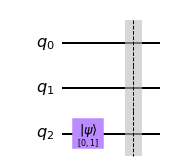

In [61]:
init_state = [0, 1] 
qc = QuantumCircuit(3)
qc.initialize(init_state,2)
qc.save_statevector()  # Tell simulator to save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output state vector.

qc.draw(output='mpl')

In [42]:
# Verifying if the output state of the circuit corresponds to the resulting state from the tensor product.

initial_state.to_matrix()

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

##### .
<div class="alert alert-block alert-success">
<b>Solution:</b>
</div>

In [43]:

def U_trotterize(t_target, trotter_steps):
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    ###EDIT CODE BELOW (Create the trotterized circuit with various number of trotter steps)
    for _ in range(trotter_steps):
        qc.append(Trot_gate, [qr[0], qr[1], qr[2]])
    
    ###DO NOT EDIT BELOW
        
    qc = qc.bind_parameters({t: t_target/trotter_steps})
    
    return qi.Operator(qc)

  0%|          | 0/50 [00:00<?, ?it/s]

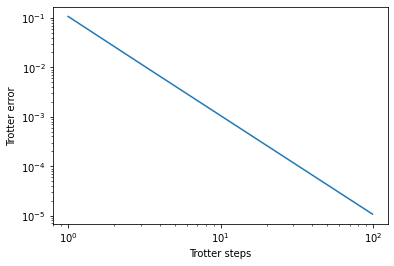

In [44]:
t_target = 0.5
U_target = U_tb(t_target)

steps=np.arange(1,101,2)  ## DO NOT EDIT

fidelities=[]
for n in tqdm(steps):
    U_trotter = U_trotterize(t_target, trotter_steps=n)
    fidelity = qi.process_fidelity(U_trotter, target=U_target)
    fidelities.append(fidelity)

plt.figure(facecolor='white')
plt.loglog(steps, 1-np.array(fidelities))
plt.ylabel('Trotter error')
plt.xlabel('Trotter steps')
plt.show()

In [ ]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex1c

grade_ex1c(fidelities)
 

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
